In [256]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.neighbors import DistanceMetric
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers
from tqdm import tqdm
import shap

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

SEED = 2020
shap.initjs()
# Any results you write to the current directory are saved as output.

/kaggle/input/flipr-hiring-challenge/Hackathon_4.0_ML_Guidelines.pdf
/kaggle/input/flipr-hiring-challenge/Train_dataset.xlsx
/kaggle/input/flipr-hiring-challenge/Test_dataset.xlsx
/kaggle/input/flipr-hiring-challenge/Variable_Description.xlsx
/kaggle/input/covid-checkpointdata/checkpoint1.csv
/kaggle/input/covidcheckpointdata2/checkpoint2.csv


In [ ]:
gt = pd.read_excel('/kaggle/input/flipr-hiring-challenge/Train_dataset.xlsx')

In [ ]:
df_train = pd.read_excel('/kaggle/input/flipr-hiring-challenge/Train_dataset.xlsx')
df_test = pd.read_excel('/kaggle/input/flipr-hiring-challenge/Test_dataset.xlsx')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
df_train.head()

In [ ]:
df_train.dtypes

In [51]:
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [ ]:
draw_missing_data_table(df_train)

In [52]:
draw_missing_data_table(df_test)

,Total,Percent
Name,32,0.002207
FT/month,0,0.000000
Age,0,0.000000
Region,0,0.000000
Gender,0,0.000000
Designation,0,0.000000
Married,0,0.000000
Children,0,0.000000
Occupation,0,0.000000
Mode_transport,0,0.000000


In [ ]:
df_train.drop('Name',axis=1,inplace=True)

In [53]:
df_test.drop('Name',axis=1,inplace=True)

## **1. Transforming the Infected_Probability variable**

In [ ]:
df_train.Infect_Prob.head()

**Converting using the Decile method:**.
We define `Threshold` Param to **55** above which are likely cases and unlikely otherwise
- 0: Signifies people very likely getting the virus `Threshold`>0.55
- 1: Signifies people unlikey getting the virus `Threshold`<0.55

In [ ]:
def fill(x):
    if x[-1]>55:
        return '1'

    elif x[-1]<55:
        return '0'

df_train['target'] = df_train.apply(lambda x:fill(x),axis=1)

In [ ]:
df_train

In [ ]:
df_train.target.value_counts().plot.bar()

## **1. Cleaning**

### **1.1 Heart Rate**

In [ ]:
df_train.drop('Designation',axis=1,inplace=True)

In [ ]:
def weighted_hamming(data):
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        data.fillna(data.mean(), inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)

    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(target, attributes, k_neighbors, aggregation_method="mean", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(target)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in target)

    # Check for possible errors
    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print ("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(target)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target


In [ ]:
%%time
df_train['Heart rate'] = knn_impute(target=df_train['Heart rate'], attributes=df_train.drop(['Heart rate','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
draw_missing_data_table(df_train)

### **1.2 D-Dimer**

In [ ]:
df_train['d-dimer'] = knn_impute(target=df_train['d-dimer'], attributes=df_train.drop(['d-dimer','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

### **1.3 Insurance**

In [ ]:
df_train['Insurance'] = knn_impute(target=df_train['Insurance'], attributes=df_train.drop(['Insurance','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

### **1.4 Platelets**

In [ ]:
df_train['Platelets'] = knn_impute(target=df_train['Platelets'], attributes=df_train.drop(['Platelets','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

### **1.5 FT/month**

In [ ]:
df_train['FT/month'] = knn_impute(target=df_train['FT/month'], attributes=df_train.drop(['FT/month','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

### **1.6 Diuresis**

In [ ]:
df_train['Diuresis'] = knn_impute(target=df_train['Diuresis'], attributes=df_train.drop(['Diuresis','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

### **1.7 Children**

In [ ]:
df_train['Children'] = knn_impute(target=df_train['Children'], attributes=df_train.drop(['Children','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

**Imputing Object Datatypes** will require a technique to preserve the NaN values as is since sklearns LabelEncoder will encode the NaN values as well.
To do this I've written a NaN_handler class which will preserve the NaN values alongwith indexes in the original dataframe.

### **1.8 Object variables:Occupation and Comorbidity**

In [ ]:
class LabelEncode_NaNhandler:
    def __init__(self,series):
        self.series = series.dropna()
        self.le = LabelEncoder()

    def fit(self):
        self.le.fit(self.series)
        return self
    
    def transform(self,original):
        transformed = []
        with tqdm(total=len(original)) as pbar:
            for row in original:
                if row==np.nan:
                    transformed.append(np.nan)
                
                else:
                    try:
                        transformed.append(self.le.transform([row])[0])
                        
                    except:
                        transformed.append(np.nan)
                pbar.update(1)
        return transformed

In [ ]:
df_train.Occupation = LabelEncode_NaNhandler(df_train.Occupation).fit().transform(df_train.Occupation.values)
df_train.comorbidity = LabelEncode_NaNhandler(df_train.comorbidity).fit().transform(df_train.comorbidity.values)

In [ ]:
%%time
df_train['Occupation'] = knn_impute(target=df_train['Occupation'], attributes=df_train.drop(['Occupation','people_ID'], 1),
                                    aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
df_train['comorbidity'] = knn_impute(target=df_train['comorbidity'], attributes=df_train.drop(['comorbidity','people_ID'], 1),
                                    aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
draw_missing_data_table(df_train)

In [ ]:
df_train.to_csv('checkpoint1.csv',index=0)

In [ ]:
df_train = pd.read_csv('/kaggle/input/covid-checkpointdata/checkpoint1.csv',index_col=None)

In [ ]:
df_train

### **Remaining NaN value Imputation**
- Values corresponding to target 0 will be droped since the *impact* will be <0.001%
- Values with target 1 will recursively imputed with the same Nearest Neighbour technique since now we have low NaN value count to hinder correctness

In [ ]:
print(len(df_train[(df_train['cardiological pressure'].isna()) & (df_train['target']==1)]))
df_train[(df_train['cardiological pressure'].isna()) & (df_train['target']==1)]

In [ ]:
index_to_drop = df_train[(df_train['cardiological pressure'].isna()) & (df_train['target']==0)].index

In [ ]:
df_train.drop(index_to_drop,inplace=True)

In [ ]:
print(len(df_train[(df_train['Heart rate'].isna()) & (df_train['target']==0)]))
#df_train[(df_train['Heart rate'].isna()) & (df_train['target']==0)]

In [ ]:
index_to_drop1 = df_train[(df_train['Heart rate'].isna()) & (df_train['target']==0)].index
index_to_drop2 = df_train[(df_train['d-dimer'].isna()) & (df_train['target']==0)].index

df_train.drop(np.concatenate([index_to_drop1,index_to_drop2]),inplace=True)

In [ ]:
draw_missing_data_table(df_train)

In [ ]:
df_train['cardiological pressure'] = LabelEncode_NaNhandler(df_train['cardiological pressure']).fit().transform(df_train['cardiological pressure'].values)

In [ ]:
df_train['cardiological pressure'] = knn_impute(target=df_train['cardiological pressure'], attributes=df_train.drop(['cardiological pressure','people_ID'], 1),
                                    aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
df_train['HDL cholesterol'] = knn_impute(target=df_train['HDL cholesterol'], attributes=df_train.drop(['HDL cholesterol','people_ID'], 1),
                                    aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
df_train['HBB'] = knn_impute(target=df_train['HBB'], attributes=df_train.drop(['HBB','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
print('Insurance         :',len(df_train[(df_train['Insurance'].isna()) & (df_train['target']==0)]))
print('Heart Rate        :',len(df_train[(df_train['Heart rate'].isna()) & (df_train['target']==0)]))
print('D-Dimer           :',len(df_train[(df_train['d-dimer'].isna()) & (df_train['target']==0)]))
print('Mode of Transport :',len(df_train[(df_train['Mode_transport'].isna()) & (df_train['target']==0)]))
print('Occupation        :',len(df_train[(df_train['Occupation'].isna()) & (df_train['target']==0)]))
print('Diuresis          :',len(df_train[(df_train['Diuresis'].isna()) & (df_train['target']==0)]))
print('FT/month          :',len(df_train[(df_train['FT/month'].isna()) & (df_train['target']==0)]))

In [ ]:
index_to_drop1 = df_train[(df_train['Insurance'].isna()) & (df_train['target']==0)].index
index_to_drop2 = df_train[(df_train['Mode_transport'].isna()) & (df_train['target']==0)].index
index_to_drop3 = df_train[(df_train['Diuresis'].isna()) & (df_train['target']==0)].index
index_to_drop4 = df_train[(df_train['FT/month'].isna()) & (df_train['target']==0)].index

df_train.drop(np.concatenate([index_to_drop1,index_to_drop2,index_to_drop3,index_to_drop4]),inplace=True)

In [ ]:
draw_missing_data_table(df_train)

In [ ]:
df_train['Heart rate'] = knn_impute(target=df_train['Heart rate'], attributes=df_train.drop(['Heart rate','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
df_train['Insurance'] = knn_impute(target=df_train['Insurance'], attributes=df_train.drop(['Insurance','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
df_train['d-dimer'] = knn_impute(target=df_train['d-dimer'], attributes=df_train.drop(['d-dimer','people_ID'], 1),
                                    aggregation_method="median", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
df_train['Occupation'] = knn_impute(target=df_train['Occupation'], attributes=df_train.drop(['Occupation','people_ID'], 1),
                                    aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
df_train['Mode_transport'] = LabelEncode_NaNhandler(df_train['Mode_transport']).fit().transform(df_train['Mode_transport'].values)
df_train['Mode_transport'] = knn_impute(target=df_train['Mode_transport'], attributes=df_train.drop(['Mode_transport','people_ID'], 1),
                                    aggregation_method="mode", k_neighbors=10, numeric_distance='euclidean',
                                    categorical_distance='hamming', missing_neighbors_threshold=0.8)

In [ ]:
draw_missing_data_table(df_train)

In [ ]:
df_train.to_csv('checkpoint2.csv',index=0)

In [146]:
df_train = pd.read_csv('/kaggle/input/covidcheckpointdata2/checkpoint2.csv',index_col=None)
df_test = pd.read_excel('/kaggle/input/flipr-hiring-challenge/Test_dataset.xlsx')

# **Feature Engineering**

### **1. Feature Encoding/Hashing**

Features to be Hashed: *Region,Gender,Pulmonary score*

In [147]:
df_train

,people_ID,Region,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,Coma score,Pulmonary score,cardiological pressure,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob,target
0,1,Bhubaneshwar,Female,YES,1.0,4.0,1.0,2,0,2.0,68,8,<400,1.0,441.0,154.0,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010,0
1,2,Bhubaneshwar,Female,YES,2.0,4.0,2.0,2,0,1.0,64,15,<100,3.0,347.5,121.0,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880,0
2,3,Bhubaneshwar,Female,NO,1.0,1.0,1.0,2,0,3.0,19,13,<300,0.0,416.0,124.0,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000,1
3,4,Bhubaneshwar,Female,YES,1.0,3.0,0.0,2,0,0.0,33,9,<200,2.0,410.0,98.0,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225,0
4,5,Bhubaneshwar,Female,NO,2.0,6.0,0.0,2,0,1.0,23,7,<400,1.0,390.0,21.0,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10569,22691,Bengaluru,Male,NO,2.0,0.0,0.0,8,2,1.0,20,14,<400,1.0,134.0,67.0,24.0,209.0,61.0,56.0,35,7,4000000.0,300000,0.0,41.981760,0
10570,22692,Bengaluru,Male,YES,0.0,6.0,0.0,8,2,3.0,42,4,<400,1.0,387.0,102.0,134.0,211.0,65.0,47.0,35,7,1500000.0,700000,1.0,47.148663,0
10571,22693,Bengaluru,Male,YES,0.0,2.0,1.0,8,2,1.0,59,3,<100,3.0,177.0,111.0,151.0,296.0,87.0,37.0,16,5,3000000.0,2100000,2.0,47.708533,0
10572,22694,Bengaluru,Male,YES,1.0,5.0,2.0,8,2,0.0,49,6,<300,0.0,352.0,140.0,110.0,253.0,56.0,70.0,28,5,2900000.0,700000,1.0,53.803565,0


In [148]:
df_test

,people_ID,Region,Gender,Designation,Name,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,Coma score,Pulmonary score,cardiological pressure,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month
0,5942,Delhi,Female,Mrs,smt rekha prajapat,YES,2,Driver,Public,4,1,Diabetes,52,3,<200,Stage-01,388,153,196,240,85,53,17,3,3900000,1300000,1
1,18664,Delhi,Male,Mr,nirmal,YES,2,Legal,Walk,4,1,Diabetes,53,11,<200,Stage-01,409,95,138,241,81,61,2,5,1800000,1300000,1
2,5603,Delhi,Female,Mrs,pinky,YES,2,Sales,Car,4,1,Diabetes,35,9,<100,Stage-02,440,40,166,236,88,47,24,3,5000000,2000000,2
3,5649,Delhi,Female,Mrs,pooja @aafrin,YES,2,Sales,Car,4,1,None,31,12,<300,Elevated,206,78,83,211,87,52,13,6,3100000,600000,2
4,5099,Delhi,Female,Mrs,anjali,YES,2,Business,Car,4,1,Diabetes,51,6,<200,Stage-01,229,109,207,312,94,68,39,5,2300000,1500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14493,23737,Thiruvananthapuram,Male,Mr,hanuman sing,YES,0,Cleaner,Walk,11,2,Coronary Heart Disease,55,5,<400,Normal,417,16,36,346,66,45,34,3,4200000,800000,2
14494,11171,Thiruvananthapuram,Female,Mrs,gurupreet kaur @ nainsi,YES,0,Clerk,Car,11,2,None,44,4,<300,Elevated,199,22,29,278,94,37,23,6,4500000,1800000,2
14495,23243,Thiruvananthapuram,Male,Mr,sonu pandey,YES,0,Business,Public,11,2,None,46,6,<300,Elevated,161,15,28,294,73,56,6,6,4300000,800000,1
14496,11199,Thiruvananthapuram,Female,Mrs,nikky,YES,0,Driver,Car,11,2,Coronary Heart Disease,34,5,<200,Stage-01,174,31,24,227,83,60,32,7,2400000,1800000,2


In [149]:
df_train['Region'] = df_train['Region'].astype(str)
df_train['Gender'] = df_train['Gender'].astype(str)
df_train['Pulmonary score'] = df_train['Pulmonary score'].astype(str)
df_train['Married'] = df_train['Married'].astype(str)
df_train['Occupation'] = df_train['Occupation'].astype(str)
df_train['Mode_transport'] = df_train['Mode_transport'].astype(str)

In [150]:
df_test['Region'] = df_test['Region'].astype(str)
df_test['Gender'] = df_test['Gender'].astype(str)
df_test['Pulmonary score'] = df_test['Pulmonary score'].astype(str)
df_test['Married'] = df_test['Married'].astype(str)
df_test['Occupation'] = df_test['Occupation'].astype(str)
df_test['Mode_transport'] = df_test['Mode_transport'].astype(str)

In [102]:
df_train.dtypes

people_ID                   int64
Region                     object
Gender                     object
Married                    object
Children                  float64
Occupation                 object
Mode_transport            float64
cases/1M                    int64
Deaths/1M                   int64
comorbidity               float64
Age                         int64
Coma score                  int64
Pulmonary score            object
cardiological pressure    float64
Diuresis                  float64
Platelets                 float64
HBB                       float64
d-dimer                   float64
Heart rate                float64
HDL cholesterol           float64
Charlson Index              int64
Blood Glucose               int64
Insurance                 float64
salary                      int64
FT/month                  float64
Infect_Prob               float64
target                      int64
dtype: object

In [103]:
df_test.dtypes

people_ID                  int64
Region                    object
Gender                    object
Designation               object
Name                      object
Married                   object
Children                   int64
Occupation                object
Mode_transport            object
cases/1M                   int64
Deaths/1M                  int64
comorbidity               object
Age                        int64
Coma score                 int64
Pulmonary score           object
cardiological pressure    object
Diuresis                   int64
Platelets                  int64
HBB                        int64
d-dimer                    int64
Heart rate                 int64
HDL cholesterol            int64
Charlson Index             int64
Blood Glucose              int64
Insurance                  int64
salary                     int64
FT/month                   int64
dtype: object

In [151]:
d = defaultdict()
HASH_FEATURES = ["Region","Gender","Pulmonary score","Married","Occupation","Mode_transport"]

for feature in HASH_FEATURES:
    fh = FeatureHasher(n_features=6, input_type='string')
    hashed_features = fh.fit_transform(df_train[feature])
    
    d[feature] = fh
    
    hashed_features = hashed_features.toarray()
    df = pd.DataFrame(hashed_features)
    df.columns = [feature + '_'+ str(col)  for col in df.columns]
    
    df_train = pd.concat([df_train, df], axis=1, sort=False)

In [152]:
for feature in HASH_FEATURES:
    fh = d[feature]
    hashed_features = fh.transform(df_test[feature])
    
    hashed_features = hashed_features.toarray()
    df = pd.DataFrame(hashed_features)
    df.columns = [feature + '_'+ str(col)  for col in df.columns]
    
    df_test = pd.concat([df_test, df], axis=1, sort=False)

In [153]:
df_train.drop(["Region","Gender","Pulmonary score","Married","people_ID","Occupation","Mode_transport"],axis=1,inplace=True)

In [138]:
df_test

,people_ID,Region,Gender,Designation,Name,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,Coma score,Pulmonary score,cardiological pressure,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Gender_0,Gender_1,Gender_2,Gender_3,Gender_4,Gender_5,Pulmonary score_0,Pulmonary score_1,Pulmonary score_2,Pulmonary score_3,Pulmonary score_4,Pulmonary score_5,Married_0,Married_1,Married_2,Married_3,Married_4,Married_5,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Mode_transport_0,Mode_transport_1,Mode_transport_2,Mode_transport_3,Mode_transport_4,Mode_transport_5
0,5942,Delhi,Female,Mrs,smt rekha prajapat,YES,2,Driver,Public,4,1,Diabetes,52,3,<200,Stage-01,388,153,196,240,85,53,17,3,3900000,1300000,1,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,-1.0,0.0,-1.0,0.0,0.0,1.0,-1.0,1.0,-3.0
1,18664,Delhi,Male,Mr,nirmal,YES,2,Legal,Walk,4,1,Diabetes,53,11,<200,Stage-01,409,95,138,241,81,61,2,5,1800000,1300000,1,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
2,5603,Delhi,Female,Mrs,pinky,YES,2,Sales,Car,4,1,Diabetes,35,9,<100,Stage-02,440,40,166,236,88,47,24,3,5000000,2000000,2,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-3.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-1.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
3,5649,Delhi,Female,Mrs,pooja @aafrin,YES,2,Sales,Car,4,1,None,31,12,<300,Elevated,206,78,83,211,87,52,13,6,3100000,600000,2,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-1.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
4,5099,Delhi,Female,Mrs,anjali,YES,2,Business,Car,4,1,Diabetes,51,6,<200,Stage-01,229,109,207,312,94,68,39,5,2300000,1500000,1,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,-4.0,1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14493,23737,Thiruvananthapuram,Male,Mr,hanuman sing,YES,0,Cleaner,Walk,11,2,Coronary Heart Disease,55,5,<400,Normal,417,16,36,346,66,45,34,3,4200000,800000,2,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,3.0,2.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
14494,11171,Thiruvananthapuram,Female,Mrs,gurupreet kaur @ nainsi,YES,0,Clerk,Car,11,2,None,44,4,<300,Elevated,199,22,29,278,94,37,23,6,4500000,1800000,2,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,0.0,0.0
14495,23243,Thiruvananthapuram,Male,Mr,sonu pandey,YES,0,Business,Public,11,2,None,46,6,<300,Elevated,161,15,28,294,73,56,6,6,4300000,800000,1,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,-4.0,1.0,0.0,0.0,0.0,1.0,-1.0,1.0,-3.0
14496,11199,Thiruvananthapuram,Female,Mrs,nikky,YES,0,Driver,Car,11,2,Coronary Heart Disease,34,5,<200,Stage-01,174,31,24,227,83,60,32,7,2400000,1800000,2,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,0.0,0.0


### **Plots and Distribution analysis**

In [121]:
df_train

,Children,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,Coma score,cardiological pressure,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob,target,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Gender_0,Gender_1,Gender_2,Gender_3,Gender_4,Gender_5,Pulmonary score_0,Pulmonary score_1,Pulmonary score_2,Pulmonary score_3,Pulmonary score_4,Pulmonary score_5,Married_0,Married_1,Married_2,Married_3,Married_4,Married_5,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5
0,1.0,1.0,2,0,2.0,68,8,1.0,441.0,154.0,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010,0,-1.0,1.0,1.0,-1.0,1.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0
1,2.0,2.0,2,0,1.0,64,15,3.0,347.5,121.0,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880,0,-1.0,1.0,1.0,-1.0,1.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-3.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,-1.0
2,1.0,1.0,2,0,3.0,19,13,0.0,416.0,124.0,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000,1,-1.0,1.0,1.0,-1.0,1.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-2.0,0.0,0.0,0.0,-1.0
3,1.0,0.0,2,0,0.0,33,9,2.0,410.0,98.0,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225,0,-1.0,1.0,1.0,-1.0,1.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0
4,2.0,0.0,2,0,1.0,23,7,1.0,390.0,21.0,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800,1,-1.0,1.0,1.0,-1.0,1.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-1.0,1.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10569,2.0,0.0,8,2,1.0,20,14,1.0,134.0,67.0,24.0,209.0,61.0,56.0,35,7,4000000.0,300000,0.0,41.981760,0,-1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-2.0,0.0,0.0,0.0,-1.0
10570,0.0,0.0,8,2,3.0,42,4,1.0,387.0,102.0,134.0,211.0,65.0,47.0,35,7,1500000.0,700000,1.0,47.148663,0,-1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0
10571,0.0,1.0,8,2,1.0,59,3,3.0,177.0,111.0,151.0,296.0,87.0,37.0,16,5,3000000.0,2100000,2.0,47.708533,0,-1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-3.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,-1.0
10572,1.0,2.0,8,2,0.0,49,6,0.0,352.0,140.0,110.0,253.0,56.0,70.0,28,5,2900000.0,700000,1.0,53.803565,0,-1.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0


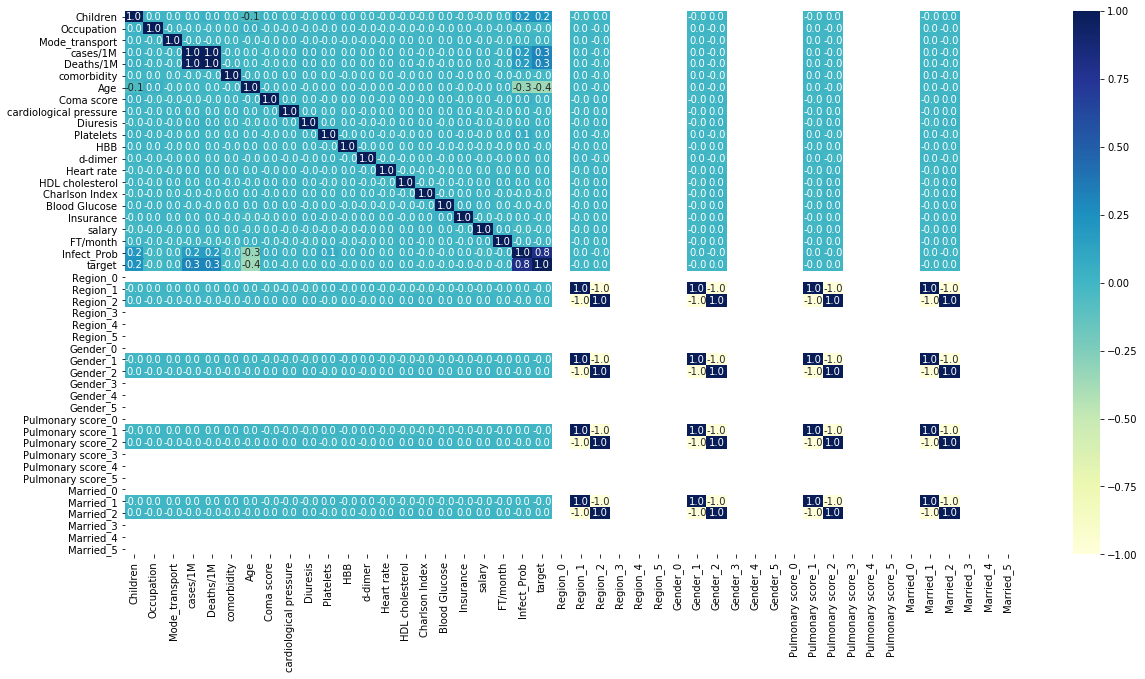

In [25]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(df_train.corr(),annot=True,fmt=".1f",cmap="YlGnBu",ax=ax)

In [27]:
df_train.corr()

,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,Coma score,cardiological pressure,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob,target,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Gender_0,Gender_1,Gender_2,Gender_3,Gender_4,Gender_5,Pulmonary score_0,Pulmonary score_1,Pulmonary score_2,Pulmonary score_3,Pulmonary score_4,Pulmonary score_5,Married_0,Married_1,Married_2,Married_3,Married_4,Married_5
Children,1.000000,0.020142,0.009666,0.021391,0.033723,0.004506,-0.050317,0.023772,0.007476,-0.014873,0.022785,0.009757,0.003018,-0.010229,-0.001292,-0.020029,0.010593,-0.006240,-0.016779,0.010029,0.214161,0.242020,NaN,-0.013270,0.013270,NaN,NaN,NaN,NaN,-0.013270,0.013270,NaN,NaN,NaN,NaN,-0.013270,0.013270,NaN,NaN,NaN,NaN,-0.013270,0.013270,NaN,NaN,NaN
Occupation,0.020142,1.000000,-0.003246,-0.002982,-0.003748,0.002451,0.039205,-0.009785,-0.006519,-0.000906,-0.001560,0.011236,-0.000031,-0.013848,-0.017435,-0.001188,-0.005760,0.008589,-0.002058,-0.001516,-0.021885,-0.020072,NaN,0.001121,-0.001121,NaN,NaN,NaN,NaN,0.001121,-0.001121,NaN,NaN,NaN,NaN,0.001121,-0.001121,NaN,NaN,NaN,NaN,0.001121,-0.001121,NaN,NaN,NaN
Mode_transport,0.009666,-0.003246,1.000000,-0.000889,-0.004026,0.004769,-0.009582,-0.008094,0.011659,-0.005438,-0.005184,-0.001714,-0.005073,-0.004283,0.012735,0.001258,0.011651,0.011060,-0.001190,-0.008931,0.004192,0.011568,NaN,0.000905,-0.000905,NaN,NaN,NaN,NaN,0.000905,-0.000905,NaN,NaN,NaN,NaN,0.000905,-0.000905,NaN,NaN,NaN,NaN,0.000905,-0.000905,NaN,NaN,NaN
cases/1M,0.021391,-0.002982,-0.000889,1.000000,0.987373,-0.006872,0.006826,-0.012771,0.006070,0.033508,0.004166,0.006133,0.003303,0.023221,0.005292,-0.001114,-0.003827,0.011762,0.008787,-0.002916,0.171533,0.307176,NaN,0.003495,-0.003495,NaN,NaN,NaN,NaN,0.003495,-0.003495,NaN,NaN,NaN,NaN,0.003495,-0.003495,NaN,NaN,NaN,NaN,0.003495,-0.003495,NaN,NaN,NaN
Deaths/1M,0.033723,-0.003748,-0.004026,0.987373,1.000000,-0.004613,0.006762,-0.009415,0.006871,0.032448,0.006458,0.010275,0.000779,0.019717,0.007955,-0.001940,-0.004899,0.010309,0.008216,-0.002712,0.173616,0.306641,NaN,0.003152,-0.003152,NaN,NaN,NaN,NaN,0.003152,-0.003152,NaN,NaN,NaN,NaN,0.003152,-0.003152,NaN,NaN,NaN,NaN,0.003152,-0.003152,NaN,NaN,NaN
comorbidity,0.004506,0.002451,0.004769,-0.006872,-0.004613,1.000000,-0.002117,0.003561,0.007895,0.003076,0.001036,-0.002399,0.001589,0.005715,-0.006880,0.004919,0.010369,-0.004832,0.004505,-0.010083,-0.005087,-0.010348,NaN,0.011661,-0.011661,NaN,NaN,NaN,NaN,0.011661,-0.011661,NaN,NaN,NaN,NaN,0.011661,-0.011661,NaN,NaN,NaN,NaN,0.011661,-0.011661,NaN,NaN,NaN
Age,-0.050317,0.039205,-0.009582,0.006826,0.006762,-0.002117,1.000000,-0.003949,0.012062,-0.010675,0.011056,0.013483,-0.005711,0.002186,-0.004874,0.003508,0.012849,-0.018547,-0.003243,0.016672,-0.332304,-0.360752,NaN,0.006938,-0.006938,NaN,NaN,NaN,NaN,0.006938,-0.006938,NaN,NaN,NaN,NaN,0.006938,-0.006938,NaN,NaN,NaN,NaN,0.006938,-0.006938,NaN,NaN,NaN
Coma score,0.023772,-0.009785,-0.008094,-0.012771,-0.009415,0.003561,-0.003949,1.000000,0.000655,0.003145,-0.014992,0.006520,0.000322,-0.007352,0.008226,-0.003717,0.017833,-0.011316,0.003161,-0.002829,0.038727,0.008822,NaN,-0.011900,0.011900,NaN,NaN,NaN,NaN,-0.011900,0.011900,NaN,NaN,NaN,NaN,-0.011900,0.011900,NaN,NaN,NaN,NaN,-0.011900,0.011900,NaN,NaN,NaN
cardiological pressure,0.007476,-0.006519,0.011659,0.006070,0.006871,0.007895,0.012062,0.000655,1.000000,0.000554,0.007417,0.004764,-0.004632,0.003482,0.009831,0.011231,0.014675,0.009551,-0.012985,-0.013495,0.007806,-0.000945,NaN,-0.005487,0.005487,NaN,NaN,NaN,NaN,-0.005487,0.005487,NaN,NaN,NaN,NaN,-0.005487,0.005487,NaN,NaN,NaN,NaN,-0.005487,0.005487,NaN,NaN,NaN
Diuresis,-0.014873,-0.000906,-0.005438,0.033508,0.032448,0.003076,-0.010675,0.003145,0.000554,1.000000,0.010060,0.004512,-0.012400,-0.005940,0.011098,0.014401,-0.013225,0.028335,-0.005482,-0.016031,0.008584,0.015125,NaN,-0.016511,0.016511,NaN,NaN,NaN,NaN,-0

In [ ]:
sns.distplot(df_train.Age)

In [ ]:
sns.pairplot(df_train,x_vars=["Gender", "Age"],
                     y_vars=["Infect_Prob"])

In [ ]:
FEATURES = ['Region', 'Gender', 'Married', 'Children', 'Occupation', 'Mode_transport', 'cases/1M', 
            'Deaths/1M', 'comorbidity', 'Age', 'Coma score', 'Pulmonary score', 'cardiological pressure', 'Diuresis', 
            'Platelets', 'HBB', 'd-dimer', 'Heart rate', 'HDL cholesterol', 'Charlson Index', 'Blood Glucose',
            'Insurance', 'salary', 'FT/month', 'Infect_Prob', 'target']
CONTRACTING_VIRUS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(FEATURES)//2, figsize=(15, 40), dpi=100)

for i, feature in enumerate(FEATURES):
    try:
        sns.distplot(df_train.loc[~CONTRACTING_VIRUS][feature], label='Not Contracting', ax=axes[i][0], color='green').set_title('NOT CONTRACTING+{}'.format(feature))
        sns.distplot(df_train.loc[CONTRACTING_VIRUS][feature], label='Contracting', ax=axes[i][0], color='red').set_title('CONTRACTING+{}'.format(feature))

        sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
        
    except:
        sns.countplot(x=feature,data=df_train)
    #sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
#     for j in range(2):
#         axes[i][j].set_xlabel('')
#         axes[i][j].tick_params(axis='x', labelsize=12)
#         axes[i][j].tick_params(axis='y', labelsize=12)
#         axes[i][j].legend()

plt.show()

Now we will see the distribution of data as a unit by clustering it and finding about how many types of clusters exist within data.
Since the data contains a mix of Ordinal,Categorical,Numerical Data a Vanilla K-means won't help finding right clusters.

In [ ]:
def gower_distance(X):
    """
    This function expects a pandas dataframe as input
    The data frame is to contain the features along the columns. Based on these features a
    distance matrix will be returned which will contain the pairwise gower distance between the rows
    All variables of object type will be treated as nominal variables and the others will be treated as 
    numeric variables.
    Distance metrics used for:
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / np.ptp(feature.values)

        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

In [ ]:
gower_dist = gower_distance(df_train)

Ponder
- Memory issue resolve
- converting categorical to numeric for better computation
- PCA on the data
- Correlation table and comparision with cramers and theils
- model fit on transformed data (with gridsearch try more methods)

In [154]:
df_train.columns

Index(['Children', 'cases/1M', 'Deaths/1M', 'comorbidity', 'Age', 'Coma score', 'cardiological pressure', 'Diuresis', 'Platelets', 'HBB', 'd-dimer', 'Heart rate', 'HDL cholesterol', 'Charlson Index', 'Blood Glucose', 'Insurance', 'salary', 'FT/month', 'Infect_Prob', 'target', 'Region_0', 'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Gender_0', 'Gender_1', 'Gender_2', 'Gender_3', 'Gender_4', 'Gender_5', 'Pulmonary score_0', 'Pulmonary score_1', 'Pulmonary score_2', 'Pulmonary score_3', 'Pulmonary score_4', 'Pulmonary score_5', 'Married_0', 'Married_1', 'Married_2', 'Married_3', 'Married_4', 'Married_5', 'Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5', 'Mode_transport_0', 'Mode_transport_1', 'Mode_transport_2', 'Mode_transport_3', 'Mode_transport_4', 'Mode_transport_5'], dtype='object')

In [162]:
df_train = df_train[['Children', 'cases/1M', 'Deaths/1M', 'Age', 'Coma score',
                     'Diuresis', 'Platelets', 'HBB', 'd-dimer', 'Heart rate', 'HDL cholesterol', 'Charlson Index',
                     'Blood Glucose', 'Insurance', 'salary', 'FT/month', 'Region_0', 'Region_1',
                     'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Gender_0', 'Gender_1', 'Gender_2', 'Gender_3',
                     'Gender_4', 'Gender_5', 'Pulmonary score_0', 'Pulmonary score_1', 'Pulmonary score_2', 'Pulmonary score_3',
                     'Pulmonary score_4', 'Pulmonary score_5', 'Married_0', 'Married_1', 'Married_2', 'Married_3', 'Married_4',
                     'Married_5', 'Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
                     'Mode_transport_0', 'Mode_transport_1', 'Mode_transport_2', 'Mode_transport_3', 'Mode_transport_4',
                     'Mode_transport_5','Infect_Prob', 'target']]


In [163]:
df_test = df_test[['people_ID','Children', 'cases/1M', 'Deaths/1M', 'Age', 'Coma score',
                     'Diuresis', 'Platelets', 'HBB', 'd-dimer', 'Heart rate', 'HDL cholesterol', 'Charlson Index',
                     'Blood Glucose', 'Insurance', 'salary', 'FT/month', 'Region_0', 'Region_1',
                     'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Gender_0', 'Gender_1', 'Gender_2', 'Gender_3',
                     'Gender_4', 'Gender_5', 'Pulmonary score_0', 'Pulmonary score_1', 'Pulmonary score_2', 'Pulmonary score_3',
                     'Pulmonary score_4', 'Pulmonary score_5', 'Married_0', 'Married_1', 'Married_2', 'Married_3', 'Married_4',
                     'Married_5', 'Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
                     'Mode_transport_0', 'Mode_transport_1', 'Mode_transport_2', 'Mode_transport_3', 'Mode_transport_4',
                     'Mode_transport_5']]

In [164]:
df_test

,people_ID,Children,cases/1M,Deaths/1M,Age,Coma score,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Gender_0,Gender_1,Gender_2,Gender_3,Gender_4,Gender_5,Pulmonary score_0,Pulmonary score_1,Pulmonary score_2,Pulmonary score_3,Pulmonary score_4,Pulmonary score_5,Married_0,Married_1,Married_2,Married_3,Married_4,Married_5,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Mode_transport_0,Mode_transport_1,Mode_transport_2,Mode_transport_3,Mode_transport_4,Mode_transport_5
0,5942,2,4,1,52,3,388,153,196,240,85,53,17,3,3900000,1300000,1,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,-1.0,0.0,-1.0,0.0,0.0,1.0,-1.0,1.0,-3.0
1,18664,2,4,1,53,11,409,95,138,241,81,61,2,5,1800000,1300000,1,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
2,5603,2,4,1,35,9,440,40,166,236,88,47,24,3,5000000,2000000,2,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-3.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-1.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
3,5649,2,4,1,31,12,206,78,83,211,87,52,13,6,3100000,600000,2,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-1.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
4,5099,2,4,1,51,6,229,109,207,312,94,68,39,5,2300000,1500000,1,0.0,1.0,2.0,-1.0,0.0,-1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,-4.0,1.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14493,23737,0,11,2,55,5,417,16,36,346,66,45,34,3,4200000,800000,2,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,-2.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,3.0,2.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0
14494,11171,0,11,2,44,4,199,22,29,278,94,37,23,6,4500000,1800000,2,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,0.0,0.0
14495,23243,0,11,2,46,6,161,15,28,294,73,56,6,6,4300000,800000,1,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,-2.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0,-4.0,1.0,0.0,0.0,0.0,1.0,-1.0,1.0,-3.0
14496,11199,0,11,2,34,5,174,31,24,227,83,60,32,7,2400000,1800000,2,-3.0,1.0,4.0,-2.0,3.0,-3.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,-2.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,-1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,0.0,0.0


In [231]:
X = df_train.drop(['Infect_Prob','target'],axis=1)
y = df_train['target']
y_prob = df_train['Infect_Prob']

X_sub = df_test.drop(["people_ID"],axis=1)

In [232]:
X.shape,y.shape

((10574, 52), (10574,))

In [233]:
X_sub.shape

(14498, 52)

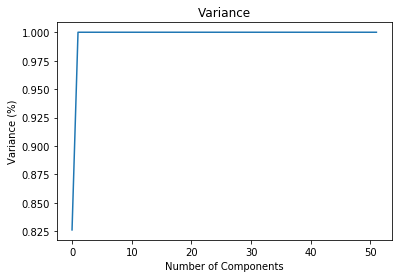

In [168]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Variance')
plt.show()

In [169]:
pca = PCA(n_components=5)
X = pca.fit_transform(X)

X_sub = pca.transform(X_sub)

In [171]:
X.shape,X_sub.shape

((10574, 5), (14498, 5))

## **Model Building**

In [234]:
class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = SEED).split(X, y))

        train_proba = np.zeros((X.shape[0], no_class))
        test_proba = np.zeros((T.shape[0], no_class))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='macro')
                f1 = f1_score(Y_valid, valid_pred, average='macro')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                ## Probabilities
                valid_proba = clf.predict_proba(X_valid)
                train_proba[valid_idx, :] = valid_proba
                test_proba  += clf.predict_proba(T)
                
                print( "Model- {} and CV- {} recall: {}, f1_score: {}".format(i, j, recall, f1))
                
            test_proba /= self.n_splits
            
        return train_proba, test_proba, train_pred, test_pred

In [182]:
print('% of target 1=',(len(df_train[df_train.target==1])/len(df_train))*100)
print('% of target 0=',(len(df_train[df_train.target==0])/len(df_train))*100)

% of target 1= 18.95214677510876
% of target 0= 81.04785322489124


In [235]:
class_weight = dict({0:8, 1:80})

In [236]:
rdf = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
            max_depth=55, max_features='auto', max_leaf_nodes=1000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False,
            random_state=SEED,
            verbose=0, warm_start=False)

In [237]:
base_models = [rdf
              #,xg
              ]
n_splits = 5
stack = Create_ensemble(n_splits = n_splits, base_models = base_models)     

In [238]:
train_proba, test_proba, train_pred, test_pred = stack.predict(X, y, X_sub)

Model- 0 and CV- 0 recall: 0.9266608857087153, f1_score: 0.8859822814391676
Model- 0 and CV- 1 recall: 0.9286512423724819, f1_score: 0.8847070799947458
Model- 0 and CV- 2 recall: 0.9227085436932756, f1_score: 0.8813688950595613
Model- 0 and CV- 3 recall: 0.9327352563748156, f1_score: 0.8932507710330648
Model- 0 and CV- 4 recall: 0.9195755542590431, f1_score: 0.8714093099584124


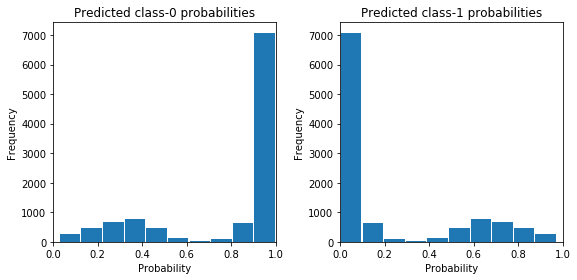

In [239]:
# histogram of predicted probabilities
plt.figure(figsize=(12, 4))
nclasses = 2
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(train_proba[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [219]:
test_proba

array([[1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99612903e-01, 3.87096774e-04],
       ...,
       [9.77110495e-01, 2.28895051e-02],
       [9.79337836e-01, 2.06621645e-02],
       [9.76619031e-01, 2.33809688e-02]])

In [220]:
test_pred

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [240]:
class custom(object):
    def __init__(self,base_models):
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        no_class = len(np.unique(y))

        train_proba = []
        test_proba = []
        valid_proba=[]
        
        train_pred = []
        test_pred = []
        f1_scores = []
        recall_scores = []
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
                
            X_train = X
            Y_train = y

            clf.fit(X_train, Y_train)

            valid_pred = clf.predict(X_train)
            recall  = recall_score(Y_train, valid_pred, average='macro')
            f1 = f1_score(Y_train, valid_pred, average='macro')

            recall_scores.append(recall)
            f1_scores.append(f1)

            train_pred.append(valid_pred)
            test_pred.append(clf.predict(T))

            ## Probabilities
            valid_proba.append(clf.predict_proba(X_train))
            train_proba.append(valid_proba)
            test_proba.append(clf.predict_proba(T))

            print( "Model- {}- recall: {}, f1_score: {}".format(i,recall, f1))
            
        return train_proba, test_proba, train_pred, test_pred,clf

In [241]:
custom_class = custom(base_models=[rdf])

In [242]:
train_proba, test_proba, train_pred, test_pred, model = custom_class.predict(X, y, X_sub)

Model- 0- recall: 0.9971995332555426, f1_score: 0.9926786745451348


In [257]:
validate = pd.DataFrame({
                            'GT':df_train['Infect_Prob'],
                            'Pred':train_proba[0][0][:,1]
                        })

mean_squared_error(validate.GT,validate.Pred)

2825.4185328613203

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


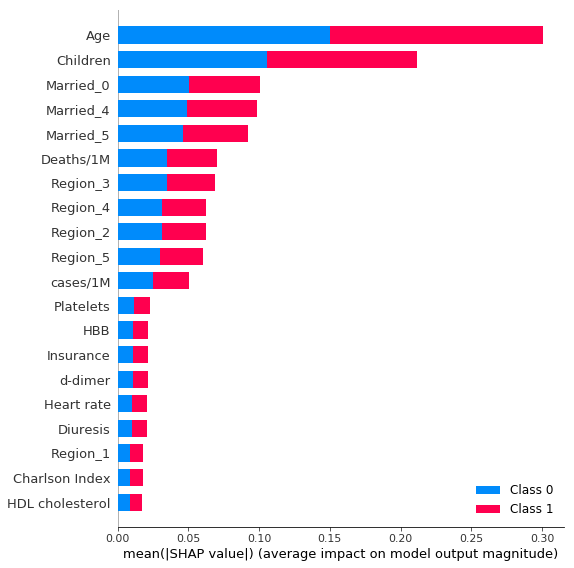

In [243]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")